In [ ]:
!nvidia-smi


Mon Dec 16 21:52:41 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0              52W / 400W |      2MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [ ]:
import os
from torchvision.datasets import CocoDetection
from torchvision.transforms import ToTensor
import torch
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torch.utils.data import DataLoader

In [ ]:
class CustomCocoDetection(CocoDetection):
    def __getitem__(self, idx):
        img, target = super().__getitem__(idx)
        image_id = self.ids[idx]

        boxes = []
        labels = []
        for ann in target:
            if 'bbox' in ann:
                x, y, w, h = ann['bbox']
                if w > 0 and h > 0:
                    boxes.append([x, y, x + w, y + h])
                    labels.append(ann['category_id'])

        if len(boxes) == 0:
            return None

        target = {
            "boxes": torch.as_tensor(boxes, dtype=torch.float32),
            "labels": torch.as_tensor(labels, dtype=torch.int64),
            "image_id": torch.tensor([image_id]),
        }

        return ToTensor()(img), target

In [ ]:
import zipfile
import os

zip_file_path = '/content/Food Detection.v11i.coco.zip'

output_dir = os.path.dirname(zip_file_path)

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(output_dir)

print(f"file unzip to: {output_dir}")


檔案已解壓縮至: /content


In [ ]:
def collate_fn(batch):
    batch = [item for item in batch if item is not None]
    return tuple(zip(*batch))

train_dir = "/content/train"
valid_dir = "/content/valid"
train_ann = "/content/train/_annotations.coco.json"
valid_ann = "/content/valid/_annotations.coco.json"

train_dataset = CustomCocoDetection(train_dir, train_ann)
valid_dataset = CustomCocoDetection(valid_dir, valid_ann)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)
valid_loader = DataLoader(valid_dataset, batch_size=4, shuffle=False, collate_fn=collate_fn)

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [ ]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn, FasterRCNN_ResNet50_FPN_Weights
import torch.nn as nn

class FastRCNNPredictor(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(FastRCNNPredictor, self).__init__()
        self.cls_score = nn.Linear(in_channels, num_classes)
        self.bbox_pred = nn.Linear(in_channels, num_classes * 4)

    def forward(self, x):
        return self.cls_score(x), self.bbox_pred(x)

weights = FasterRCNN_ResNet50_FPN_Weights.DEFAULT
model = fasterrcnn_resnet50_fpn(weights=weights)

num_classes = 30 + 1
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 207MB/s]


In [ ]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters(), lr=0.0001)

num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for images, targets in train_loader:
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        optimizer.zero_grad()
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        losses.backward()
        optimizer.step()
        total_loss += losses.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss:.4f}")


Epoch [1/100], Loss: 62.4716
Epoch [2/100], Loss: 45.7461
Epoch [3/100], Loss: 36.5910
Epoch [4/100], Loss: 30.9169
Epoch [5/100], Loss: 24.9620
Epoch [6/100], Loss: 22.9173
Epoch [7/100], Loss: 19.3328
Epoch [8/100], Loss: 16.6035
Epoch [9/100], Loss: 13.8392
Epoch [10/100], Loss: 12.6899
Epoch [11/100], Loss: 11.8183
Epoch [12/100], Loss: 10.0629
Epoch [13/100], Loss: 9.6255
Epoch [14/100], Loss: 9.5037
Epoch [15/100], Loss: 8.6060
Epoch [16/100], Loss: 8.2468
Epoch [17/100], Loss: 8.1772
Epoch [18/100], Loss: 7.5534
Epoch [19/100], Loss: 7.5523
Epoch [20/100], Loss: 7.1782
Epoch [21/100], Loss: 6.5020
Epoch [22/100], Loss: 6.4207
Epoch [23/100], Loss: 6.2291
Epoch [24/100], Loss: 6.5285
Epoch [25/100], Loss: 5.8352
Epoch [26/100], Loss: 5.5268
Epoch [27/100], Loss: 5.4373
Epoch [28/100], Loss: 5.2277
Epoch [29/100], Loss: 5.0392
Epoch [30/100], Loss: 4.9042
Epoch [31/100], Loss: 4.9588
Epoch [32/100], Loss: 4.7611
Epoch [33/100], Loss: 4.5204
Epoch [34/100], Loss: 4.7417
Epoch [35/1

In [ ]:
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
import json

def evaluate(model, data_loader, ann_file):
    model.eval()
    results = []
    coco_gt = COCO(ann_file)

    with torch.no_grad():
        for images, targets in data_loader:
            images = [img.to(device) for img in images]
            outputs = model(images)

            for target, output in zip(targets, outputs):
                image_id = target["image_id"].item()
                for box, score, label in zip(output["boxes"], output["scores"], output["labels"]):
                    results.append({
                        "image_id": image_id,
                        "category_id": label.item(),
                        "bbox": [box[0].item(), box[1].item(), box[2].item() - box[0].item(), box[3].item() - box[1].item()],
                        "score": score.item()
                    })

    with open("results.json", "w") as f:
        json.dump(results, f)

    coco_dt = coco_gt.loadRes("results.json")
    coco_eval = COCOeval(coco_gt, coco_dt, iouType="bbox")
    coco_eval.evaluate()
    coco_eval.accumulate()
    coco_eval.summarize()

evaluate(model, valid_loader, valid_ann)


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.14s).
Accumulating evaluation results...
DONE (t=0.12s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.336
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.485
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.373
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.121
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.362
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.357
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.370
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDet

In [ ]:
from torchvision.ops import box_iou

matched_gt_labels = []
matched_pred_labels = []
matched_scores = []

model.eval()
with torch.no_grad():
    for images, targets in valid_loader:
        images = [img.to(device) for img in images]
        outputs = model(images)

        for target, output in zip(targets, outputs):
            gt_boxes = target["boxes"].cpu()
            gt_labels = target["labels"].cpu()
            pred_boxes = output["boxes"].cpu()
            pred_labels = output["labels"].cpu()
            scores = output["scores"].cpu()

            ious = box_iou(gt_boxes, pred_boxes)
            for i, gt_label in enumerate(gt_labels):
                max_iou_idx = ious[i].argmax().item()
                if ious[i][max_iou_idx] > 0.5:
                    matched_gt_labels.append(gt_label.item())
                    matched_pred_labels.append(pred_labels[max_iou_idx].item())
                    matched_scores.append(scores[max_iou_idx].item())

print(f"GT Labels: {len(matched_gt_labels)}, Pred Labels: {len(matched_pred_labels)}, Scores: {len(matched_scores)}")


GT Labels: 315, Pred Labels: 315, Scores: 315


Covariance Matrix:
[[69.70937216 57.59818016 -0.15070405]
 [57.59818016 70.48371247  0.08553069]
 [-0.15070405  0.08553069  0.10779808]]


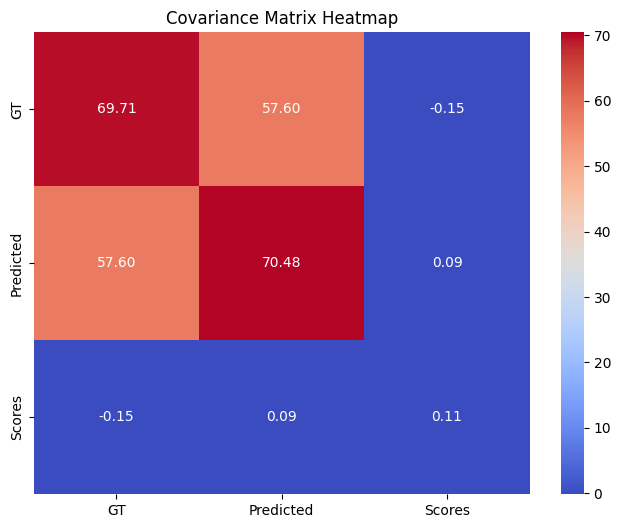

In [ ]:
data_matrix = np.vstack([
    np.array(matched_gt_labels),
    np.array(matched_pred_labels),
    np.array(matched_scores)
])

cov_matrix = np.cov(data_matrix)

print("Covariance Matrix:")
print(cov_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(cov_matrix, annot=True, cmap="coolwarm", fmt=".2f",
            xticklabels=["GT", "Predicted", "Scores"], yticklabels=["GT", "Predicted", "Scores"])
plt.title("Covariance Matrix Heatmap")
plt.show()


In [ ]:
from torchvision.ops import box_iou
import numpy as np
import torch
from collections import defaultdict

class_data = defaultdict(list)

model.eval()
with torch.no_grad():
    for images, targets in valid_loader:
        images = [img.to(device) for img in images]
        outputs = model(images)

        for target, output in zip(targets, outputs):
            gt_boxes = target["boxes"].cpu()
            gt_labels = target["labels"].cpu()
            pred_boxes = output["boxes"].cpu()
            pred_labels = output["labels"].cpu()
            scores = output["scores"].cpu()

            ious = box_iou(gt_boxes, pred_boxes)

            for i, gt_label in enumerate(gt_labels):
                max_iou_idx = ious[i].argmax().item()
                if ious[i][max_iou_idx] > 0.5:
                    x, y, x2, y2 = pred_boxes[max_iou_idx]
                    width, height = x2 - x, y2 - y

                    class_data[gt_label.item()].append([x.item(), y.item(), width.item(), height.item(), scores[max_iou_idx].item()])

for class_id, data in class_data.items():
    data = np.array(data)
    if data.shape[0] > 1:
        cov_matrix = np.cov(data, rowvar=False)
        print(f"Class ID: {class_id}")
        print("Covariance Matrix:")
        print(cov_matrix)
        print()


Class ID: 4
Covariance Matrix:
[[ 2.50435410e+03 -2.13365472e+02 -3.33502834e+03 -1.18024938e+02
  -1.25957201e+00]
 [-2.13365472e+02  2.73035390e+03 -6.73410176e+00 -2.31829631e+03
   1.34110495e+00]
 [-3.33502834e+03 -6.73410176e+00  6.53879088e+03  8.63506182e+02
   2.57649169e+00]
 [-1.18024938e+02 -2.31829631e+03  8.63506182e+02  2.77733268e+03
  -1.16651242e+00]
 [-1.25957201e+00  1.34110495e+00  2.57649169e+00 -1.16651242e+00
   3.00991316e-03]]

Class ID: 17
Covariance Matrix:
[[ 1.05557231e+04  4.07784207e+02 -1.73550063e+03 -1.46042308e+02
   2.35773581e+00]
 [ 4.07784207e+02  9.63802827e+03  5.98853306e+02  2.52541838e+02
  -3.08212775e+00]
 [-1.73550063e+03  5.98853306e+02  1.37707189e+03  3.83444353e+02
  -4.92123896e+00]
 [-1.46042308e+02  2.52541838e+02  3.83444353e+02  9.72326774e+02
  -1.69555428e+00]
 [ 2.35773581e+00 -3.08212775e+00 -4.92123896e+00 -1.69555428e+00
   1.10442288e-01]]

Class ID: 7
Covariance Matrix:
[[ 7.99074638e+03 -6.45926496e+02 -1.32143358e+03  8

<ipython-input-52-b5b7bc26c8d0>:42: RuntimeWarning: invalid value encountered in divide
  cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


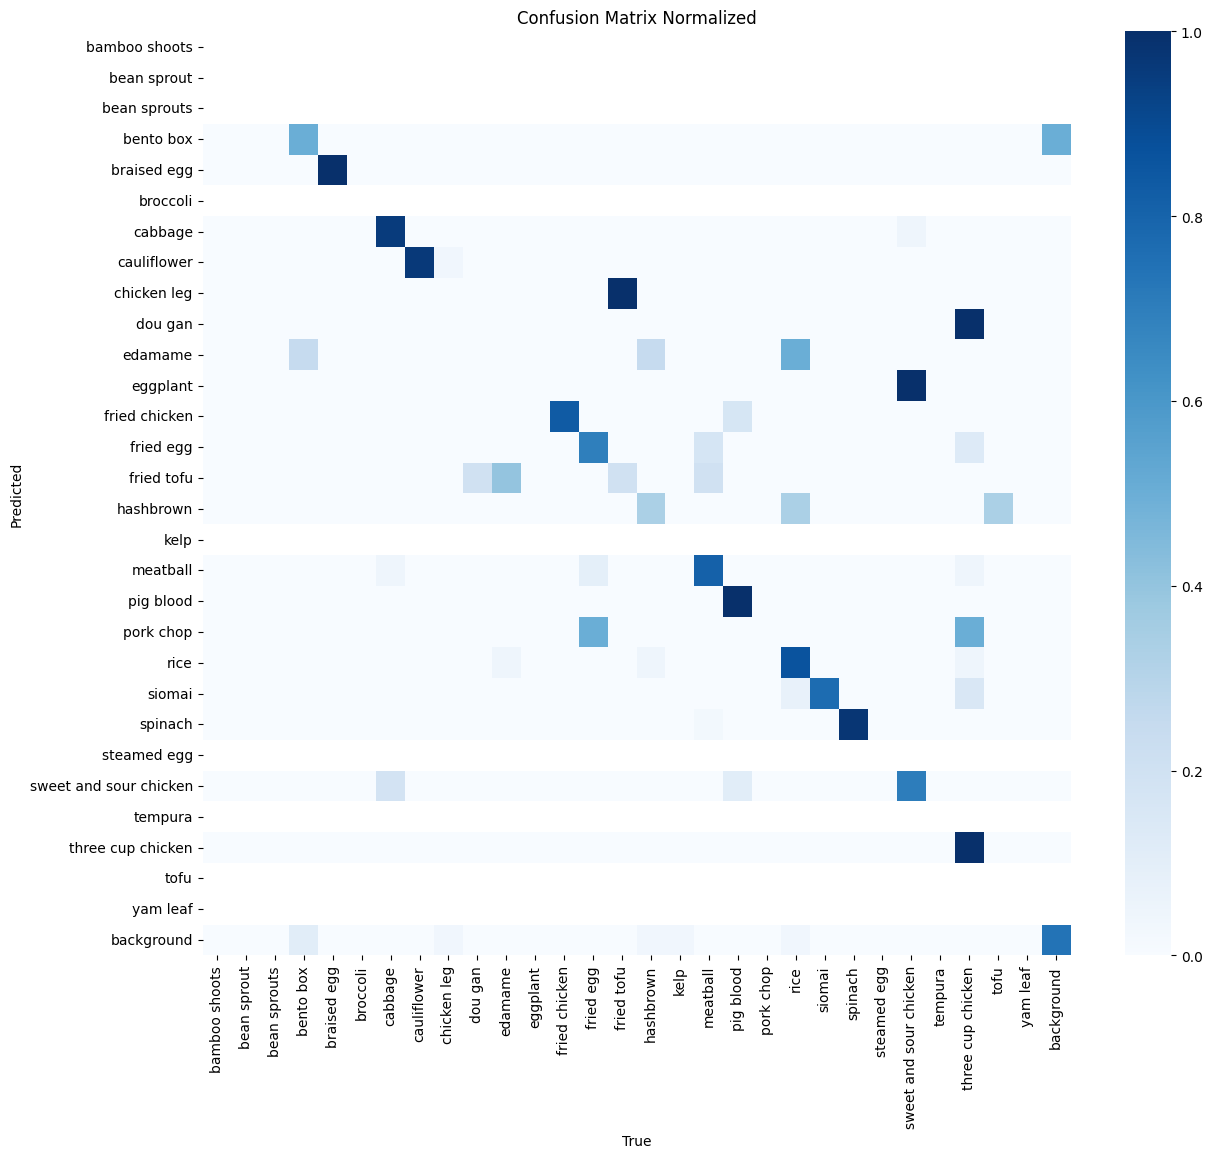

In [ ]:
from torchvision.ops import box_iou
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

matched_gt_labels = []
matched_pred_labels = []

model.eval()
with torch.no_grad():
    for images, targets in valid_loader:
        images = [img.to(device) for img in images]
        outputs = model(images)

        for target, output in zip(targets, outputs):
            gt_boxes = target["boxes"].cpu()
            gt_labels = target["labels"].cpu()
            pred_boxes = output["boxes"].cpu()
            pred_labels = output["labels"].cpu()

            ious = box_iou(gt_boxes, pred_boxes)

            for i, gt_label in enumerate(gt_labels):
                max_iou_idx = ious[i].argmax().item()
                if ious[i][max_iou_idx] > 0.5:
                    matched_gt_labels.append(gt_label.item())
                    matched_pred_labels.append(pred_labels[max_iou_idx].item())

labels = ["bamboo shoots", "bean sprout", "bean sprouts", "bento box", "braised egg",
          "broccoli", "cabbage", "cauliflower", "chicken leg", "dou gan", "edamame",
          "eggplant", "fried chicken", "fried egg", "fried tofu", "hashbrown", "kelp",
          "meatball", "pig blood", "pork chop", "rice", "siomai", "spinach", "steamed egg",
          "sweet and sour chicken", "tempura", "three cup chicken", "tofu", "yam leaf", "background"]

cm = confusion_matrix(matched_gt_labels, matched_pred_labels, labels=range(len(labels)))
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(14, 12))
sns.heatmap(cm_normalized, annot=False, cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix Normalized")
plt.xlabel("True")
plt.ylabel("Predicted")
plt.show()


In [ ]:
import time
from torchvision.transforms import ToTensor
from PIL import Image

image_path = "/content/test/IMG_5449_jpeg.rf.0490d5e0da92a904faf0221fc05caa17.jpg"
image = ToTensor()(Image.open(image_path)).unsqueeze(0).to(device)

model.eval()

start_time = time.time()
with torch.no_grad():
    output = model(image)
end_time = time.time()

elapsed_time = end_time - start_time
print(f"Faster R-CNN read time: {elapsed_time:.4f} 秒")


Faster R-CNN read time: 0.0268 秒


In [ ]:
import time
import torch
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.transforms import ToTensor
from PIL import Image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = fasterrcnn_resnet50_fpn(pretrained=True).to(device)
model.eval()

image_path = "/content/test/IMG_5449_jpeg.rf.0490d5e0da92a904faf0221fc05caa17.jpg"
image = ToTensor()(Image.open(image_path)).unsqueeze(0).to(device)

starter, ender = torch.cuda.Event(enable_timing=True), torch.cuda.Event(enable_timing=True)
starter.record()

with torch.no_grad():
    output = model(image)

ender.record()
torch.cuda.synchronize()
elapsed_time = starter.elapsed_time(ender)

print(f"Faster R-CNN time: {elapsed_time:.2f} msec")


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Faster R-CNN 單張圖片推論時間: 30.12 毫秒


In [ ]:
import time
import torch
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.transforms import ToTensor
from PIL import Image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_frcnn = fasterrcnn_resnet50_fpn(pretrained=True).to(device)
model_frcnn.eval()

image_path = "/content/test/IMG_5449_jpeg.rf.0490d5e0da92a904faf0221fc05caa17.jpg"
image = ToTensor()(Image.open(image_path)).unsqueeze(0).to(device)

starter, ender = torch.cuda.Event(enable_timing=True), torch.cuda.Event(enable_timing=True)
starter.record()

with torch.no_grad():
    output_frcnn = model_frcnn(image)

ender.record()
torch.cuda.synchronize()
fasterrcnn_time = starter.elapsed_time(ender)

print(f"Using Faster R-CNN : {fasterrcnn_time:.2f} msec")


Using Faster R-CNN : 29.89 msec


ValueError: Found input variables with inconsistent numbers of samples: [386, 612]

In [ ]:
from torchvision.ops import nms

def apply_nms(boxes, scores, iou_threshold=0.5):
    indices = nms(torch.tensor(boxes), torch.tensor(scores), iou_threshold)
    return boxes[indices], scores[indices]

boxes = output["boxes"].detach().cpu().numpy()
scores = output["scores"].detach().cpu().numpy()
boxes, scores = apply_nms(boxes, scores, iou_threshold=0.5)

visualize_prediction(image_path, boxes, scores, threshold=0.5)


NameError: name 'output' is not defined

選擇的圖片: /content/valid/IMG_5471_jpeg.rf.8c29943a31ff2fb53736ca60b5fdfb8d.jpg


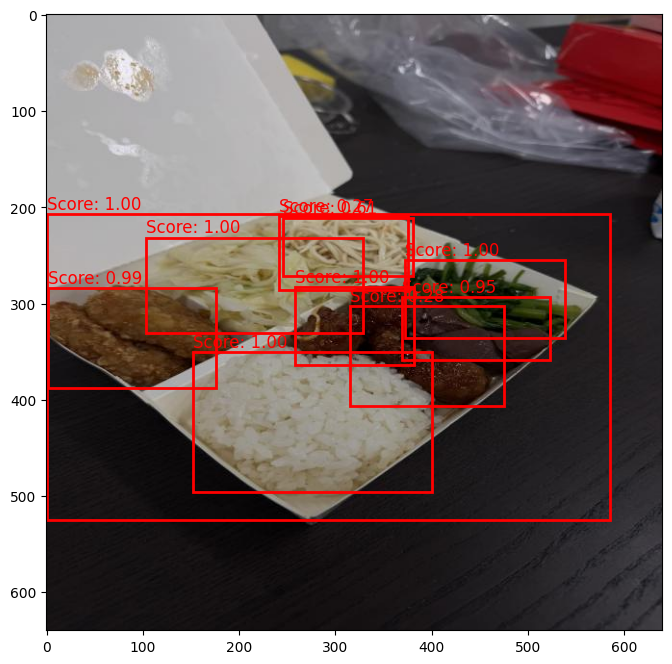

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import os

def visualize_prediction(image_path, boxes, scores):
    img = Image.open(image_path)
    plt.figure(figsize=(12, 8))
    plt.imshow(img)
    ax = plt.gca()
    for box, score in zip(boxes, scores):
        rect = patches.Rectangle(
            (box[0], box[1]),
            box[2] - box[0],
            box[3] - box[1],
            linewidth=2, edgecolor='r', facecolor='none'
        )
        ax.add_patch(rect)
        plt.text(box[0], box[1] - 5, f"Score: {score:.2f}", color="red", fontsize=12)
    plt.show()

valid_dir = "/content/valid/"
image_files = [f for f in os.listdir(valid_dir) if f.endswith(('.jpg', '.png'))]

if len(image_files) > 0:
    image_path = os.path.join(valid_dir, image_files[0])
    print(f"選擇的圖片: {image_path}")
else:
    raise FileNotFoundError(f"在目錄 {valid_dir} 中沒有找到圖片文件")

output = model([ToTensor()(Image.open(image_path)).to(device)])[0]

boxes = output["boxes"].detach().cpu().numpy()
scores = output["scores"].detach().cpu().numpy()

visualize_prediction(image_path, boxes, scores)


In [ ]:
import os
valid_dir = "/content/valid/"
files = os.listdir(valid_dir)
print(files)


['IMG_5471_jpeg.rf.8c29943a31ff2fb53736ca60b5fdfb8d.jpg', 'IMG_5523_jpeg.rf.c200ff5cfa1def379277742f040e089f.jpg', 'IMG_0746-_jpeg.rf.cd3a17272824ee664f8e7fdd59c40ade.jpg', 'IMG_5483_jpeg.rf.f3dacd21492793f99d391b1493428b06.jpg', 'IMG_5481_jpeg.rf.d65a8aca1f5607abb55380b5db5fb05a.jpg', 'IMG_5468_jpeg.rf.d096aa762f724e935a6b094e4e9bcf0c.jpg', 'IMG_5519_jpeg.rf.387de104dff30be1178a1fac97c4f050.jpg', '1211_104_jpg.rf.3f6d0e5242244fa2615fc5691a376292.jpg', 'IMG_5517_jpeg.rf.b63de8f1e5da69fae4ea472b0e62b373.jpg', 'IMG_5522_jpeg.rf.a9f759eff6f2d263d05ad51584ddff5d.jpg', 'IMG_5486_jpeg.rf.1507e074d9da140890c211a65420d0e2.jpg', '1009-106_jpg.rf.63b85a50d80638696f56aedbcb30b857.jpg', '1212_99_jpg.rf.a275e90939217ded60a8e59d899d873a.jpg', '1733206817278-_jpg.rf.514c63c5dc4bf0f652170419ed7f0ac6.jpg', 'IMG_3373-Angela_jpeg.rf.33e9caa272968f2d90ebfb6f9b0c39fb.jpg', 'IMG_5472_jpeg.rf.1260f253eb7c8461718b50dde40040d4.jpg', 'IMG_5461_jpeg.rf.69077c9d12d6840abf84eee75169aba1.jpg', 'IMG_5445_jpeg.rf.760

In [ ]:
import torch
from torchvision.ops import box_iou
from pycocotools.coco import COCO
from sklearn.metrics import confusion_matrix, precision_recall_curve, f1_score
import numpy as np

coco_gt = COCO(valid_annotations)
image_ids = coco_gt.getImgIds()

all_gt_labels = []
all_pred_labels = []
all_scores = []

model.eval()
for img_id in image_ids:
    img_info = coco_gt.loadImgs(img_id)[0]
    img_path = os.path.join(valid_dir, img_info['file_name'])
    image = ToTensor()(Image.open(img_path)).to(device)

    with torch.no_grad():
        output = model([image])[0]

    pred_boxes = output["boxes"].detach().cpu().numpy()
    pred_scores = output["scores"].detach().cpu().numpy()
    pred_labels = output["labels"].detach().cpu().numpy()

    ann_ids = coco_gt.getAnnIds(imgIds=img_id)
    anns = coco_gt.loadAnns(ann_ids)
    gt_boxes = np.array([ann['bbox'] for ann in anns])
    gt_labels = np.array([ann['category_id'] for ann in anns])

    all_gt_labels.extend(gt_labels)
    all_pred_labels.extend(pred_labels)
    all_scores.extend(pred_scores)


NameError: name 'valid_annotations' is not defined

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(all_gt_labels, all_pred_labels, labels=np.arange(1, 31))  # 類別數量=30

cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(12, 10))
sns.heatmap(cm_normalized, annot=False, cmap="Blues")
plt.title("Confusion Matrix Normalized")
plt.ylabel("Predicted")
plt.xlabel("True")
plt.show()


NameError: name 'all_gt_labels' is not defined

In [ ]:
print(f"Number of ground truth labels: {len(all_gt_labels)}")
print(f"Number of predicted labels: {len(all_pred_labels)}")


In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np

len_gt = len(all_gt_labels)
len_pred = len(all_pred_labels)

if len_gt > len_pred:
    all_pred_labels.extend([0] * (len_gt - len_pred))
elif len_gt < len_pred:
    all_gt_labels.extend([0] * (len_pred - len_gt))

print(f"Length of Ground Truth: {len(all_gt_labels)}")
print(f"Length of Predictions: {len(all_pred_labels)}")

cm = confusion_matrix(all_gt_labels, all_pred_labels, labels=np.arange(1, 31))

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d")
plt.title("faster RCNN Confusion Matrix with Padding")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


In [ ]:
from sklearn.metrics import precision_recall_curve, f1_score

precision, recall, thresholds = precision_recall_curve(all_gt_labels, all_scores)

f1 = 2 * (precision * recall) / (precision + recall + 1e-8)

plt.figure(figsize=(8, 6))
plt.plot(thresholds, f1[:-1], color="blue", label="F1-Confidence Curve")
plt.xlabel("Confidence Threshold")
plt.ylabel("F1 Score")
plt.title("F1-Confidence Curve")
plt.legend()
plt.grid()
plt.show()


In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score

binary_gt_labels = np.array([1 if label != 0 else 0 for label in all_gt_labels])
binary_scores = np.array(all_scores)

precision, recall, thresholds = precision_recall_curve(binary_gt_labels, binary_scores)
average_precision = average_precision_score(binary_gt_labels, binary_scores)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color="blue", lw=2, label=f"Micro Avg AP={average_precision:.2f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("fasterRCNN Precision-Recall Curve")
plt.legend()
plt.grid()
plt.show()


In [ ]:
epochs = range(1, len(train_losses) + 1)
train_losses = [...]
val_losses = [...]

plt.figure(figsize=(12, 6))
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid()
plt.show()


In [ ]:
import torch
from torchvision.transforms import ToTensor
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os

model.eval()

test_dir = "/content/Food_Detection.v11i.coco/test"
test_images = [os.path.join(test_dir, f) for f in os.listdir(test_dir) if f.endswith('.jpg')]

class_names = [
    "bamboo shoots", "bean sprout", "bean sprouts", "bento box", "braised egg", "broccoli", "cabbage",
    "cauliflower", "chicken leg", "dou gan", "edamame", "eggplant", "fried chicken", "fried egg",
    "fried tofu", "has", "hashbrown", "kelp", "meatball", "pig blood", "pork chop", "rice", "siomai",
    "spinach", "steamed egg", "sweet and sour chicken", "tempura", "three cup chicken", "tofu", "yam leaf"
]

def visualize_prediction(image_path, boxes, labels, scores, threshold=0.5):
    img = Image.open(image_path).convert("RGB")
    fig, ax = plt.subplots(1, figsize=(12, 8))
    ax.imshow(img)

    for box, label, score in zip(boxes, labels, scores):
        if score >= threshold:
            xmin, ymin, xmax, ymax = box
            corrected_label = label - 1
            rect = patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
            ax.text(xmin, ymin - 5, f"{class_names[corrected_label]}: {score:.2f}", color='red', fontsize=8)

    plt.axis('off')
    plt.show()


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for img_path in test_images[:20]:
    image = ToTensor()(Image.open(img_path).convert("RGB")).to(device)
    with torch.no_grad():
        output = model([image])[0]

    boxes = output["boxes"].cpu().numpy()
    labels = output["labels"].cpu().numpy()
    scores = output["scores"].cpu().numpy()

    visualize_prediction(img_path, boxes, labels, scores, threshold=0.5)


In [ ]:
import os

def visualize_and_save_prediction(image_path, boxes, labels, scores, save_dir, threshold=0.5):
    img = Image.open(image_path).convert("RGB")
    fig, ax = plt.subplots(1, figsize=(12, 8))
    ax.imshow(img)

    for box, label, score in zip(boxes, labels, scores):
        if score >= threshold:
            xmin, ymin, xmax, ymax = box
            corrected_label = label - 1
            rect = patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
            ax.text(xmin, ymin - 5, f"{class_names[corrected_label]}: {score:.2f}", color='red', fontsize=8)

    plt.axis('off')

    os.makedirs(save_dir, exist_ok=True)

    save_path = os.path.join(save_dir, os.path.basename(image_path))
    plt.savefig(save_path, bbox_inches='tight', pad_inches=0.1)
    plt.close(fig)
    print(f"Saved: {save_path}")

save_directory = "./test_results"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for img_path in test_images[:20]:
    image = ToTensor()(Image.open(img_path).convert("RGB")).to(device)
    with torch.no_grad():
        output = model([image])[0]

    boxes = output["boxes"].cpu().numpy()
    labels = output["labels"].cpu().numpy()
    scores = output["scores"].cpu().numpy()

    visualize_and_save_prediction(img_path, boxes, labels, scores, save_directory, threshold=0.5)


In [ ]:
for i, name in enumerate(class_names):
    print(f"Class {i}: {name}")


In [ ]:
!zip -r test_results.zip /content


In [ ]:
from google.colab import files
files.download("test_results.zip")
